# Analysing quick performance for etcd rw lock performance

In [1]:
import os

def get_time(line):
    parts = line.strip().split(':')
    try:
        int(parts[1].strip()[-2])
    except ValueError:
        time_part = parts[1].strip()[:-2]
        unit_part = parts[1].strip()[-2:]
        if unit_part == 'ms':
            return float(time_part)
        if unit_part == 'ns':
            return float(time_part) * 1000000
        if unit_part == 'µs':
            return float(time_part) * 1000
        else:
            raise Exception('unhandled unit', line)

    time_part = parts[1].strip()[:-1]
    unit_part = parts[1].strip()[-1:]
    if unit_part == 's':
        return float(time_part) / 1000.0
    else:
        raise Exception('unhandled unit', line)


def get_data(folder):
    result = {}
    for i in range(5):
        if os.path.isfile(os.path.join(folder, 'log'+str(i))):
            with open(os.path.join(folder, 'log'+str(i))) as f:
                result[str(i)+'read-acquire'] = []
                result[str(i)+'read-release'] = []
                result[str(i)+'write-acquire'] = []
                result[str(i)+'write-release'] = []
                for line in f.readlines():
                    if line.strip().startswith('time to acquire read lock :'):
                        time = get_time(line)
                        result[str(i)+'read-acquire'] += [time]
                    elif line.strip().startswith('time to release read lock :'):
                        time = get_time(line)
                        result[str(i)+'read-release'] += [time]
                    elif line.strip().startswith('time to acquire lock:'):
                        time = get_time(line)
                        result[str(i)+'write-acquire'] += [time]
                    elif line.strip().startswith('time to release lock:'):
                        time = get_time(line)
                        result[str(i)+'write-release'] += [time]                        
    return result


def get_log(folder):
    result = {}
    if os.path.isfile(os.path.join(folder, 'log00')):
        with open(os.path.join(folder, 'log00')) as f:
            result['read-acquire'] = []
            result['read-release'] = []
            result['write-acquire'] = []
            result['write-release'] = []
            for line in f.readlines():
                if line.strip().startswith('time to acquire read lock :'):
                    time = get_time(line)
                    result['read-acquire'] += [time]
                elif line.strip().startswith('time to release read lock :'):
                    time = get_time(line)
                    result['read-release'] += [time]
                elif line.strip().startswith('time to acquire lock:'):
                    time = get_time(line)
                    result['write-acquire'] += [time]
                elif line.strip().startswith('time to release lock:'):
                    time = get_time(line)
                    result['write-release'] += [time]                        
    return result


import numpy as np
import matplotlib.pyplot as plt

def generate_plots(data, name=''):
    fig, ax = plt.subplots(figsize=(14,8))
    x_pos = np.arange(len(data))
    for d in data:
        for val in data[d]:
            ax.plot(d, val, 'x', color='blue')
        
    plt.xticks(rotation=90)
    plt.grid(axis='y')
#     plt.savefig(name2+'/raw'+name1+'.png')
    plt.savefig('benchmark'+name+'.eps', format='eps', bbox_inches='tight')
    plt.show()


# Single client sequential operation - no contention - 1 node cluster with lock manager

In [14]:
def get_time_single(line):
    extras = line.index('processing time')
    line = line[:extras]
    time_part = line.strip()[:-2]
    unit_part = line.strip()[-2:]
    if unit_part == 'ms':
        return float(time_part)
    if unit_part == 'ns':
        return float(time_part) * 1000000
    if unit_part == 'µs':
        return float(time_part) * 1000
    if unit_part[1] == 's' and int(unit_part[0]):
        return float(line.strip()[:-1]) / 1000.0
    else:
        raise Exception('unhandled unit', line)

replicas = {1:'Houston', 2:'Paris',3:'Singapore'}
reps = {1:'H', 2:'P', 3:'S'}
modemap = {'ex':'EX', 'sh':'SH'}

def get_log_single(folder):
    result = {}
    for place in [1,2,3]:
        for mode in ['ex', 'sh']:
            result[replicas[place]+'-'+modemap[mode]]= {}
            for rep in [1,2,3]:
                logfile = 'log'+str(place)+'-'+mode+'-'+str(rep)
                if os.path.isfile(os.path.join(folder, logfile)):
                    with open(os.path.join(folder, logfile)) as f:
                        result[replicas[place]+'-'+modemap[mode]][reps[rep]] = []
                        for line in f.readlines():
                            time = get_time_single(line)
                            result[replicas[place]+'-'+modemap[mode]][reps[rep]] += [time-0.5]
    return result

In [15]:
folder = os.path.join('/', 'Users', 'snair', 'works', 'dislock-experiments', 'goresults', 'manager', 'predictions')

data = get_log_single(folder)
for d in data:
    print(d)
    for dd in data[d]:
        print(dd)
        print('100th', np.percentile(data[d][dd],100), '99th:', np.percentile(data[d][dd],99),
              '95th', np.percentile(data[d][dd],95),'90th', np.percentile(data[d][dd],90),
              '75th', np.percentile(data[d][dd],75),'50th', np.percentile(data[d][dd],50), 
              '25th', np.percentile(data[d][dd],25), '10th', np.percentile(data[d][dd],10), 
              '5th', np.percentile(data[d][dd],5), '1st', np.percentile(data[d][dd],1), 'mean', np.mean(data[d][dd]))
# generate_plots(data)




Houston-EX
H
100th 7.888645 99th: 5.678536539999999 95th 4.25906135 90th 3.9487965 75th 3.5949075000000006 50th 3.2393315 25th 2.8771327500000003 10th 2.5990968 5th 2.42472675 1st 2.17708942 mean 3.2954730850000002
P
100th 226.994337 99th: 225.92217118 95th 224.68535985 90th 224.4289417 75th 224.09693725 50th 223.72012 25th 223.36085300000002 10th 223.12299499999997 5th 223.00952785 1st 222.72737121 mean 223.78096148900002
S
100th 507.639686 99th: 505.95717292999996 95th 504.75224025 90th 504.5022444 75th 504.21762225 50th 503.9163505 25th 503.57324475 10th 503.32230660000005 5th 503.1880142 1st 502.90741079000003 mean 503.93539986400003
Houston-SH
H
100th 6.325153 99th: 5.152696269999999 95th 3.5356262999999992 90th 3.38608 75th 3.19111325 50th 2.9938070000000003 25th 2.734789 10th 2.5140755 5th 2.3673224499999996 1st 2.09667743 mean 3.0035555910000005
P
100th 227.812155 99th: 225.5690598 95th 224.14423275 90th 223.9064087 75th 223.73674224999996 50th 223.51545 25th 223.252774 10th 22

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

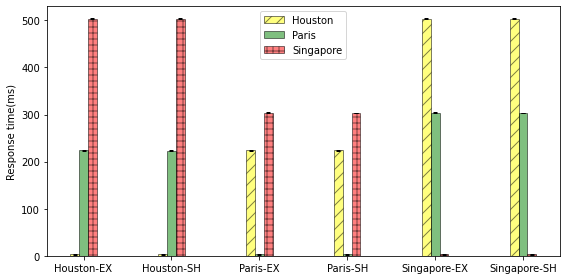

In [34]:
fig, ax = plt.subplots(figsize=(8,4))

labels = [config for config in data]
houston_means = [np.mean(data[config]['H']) for config in data]
paris_means = [np.mean(data[config]['P']) for config in data]
singapore_means = [np.mean(data[config]['S']) for config in data]
houston_err = [np.std(data[config]['H']) for config in data]
paris_err = [np.std(data[config]['P']) for config in data]
singapore_err = [np.std(data[config]['S']) for config in data]

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

rects1 = ax.bar(x - width, houston_means, width, yerr=houston_err, label='Houston', align='center', alpha=0.5, color='yellow', edgecolor='black', hatch='//', capsize=2)
rects2 = ax.bar(x, paris_means, width, yerr=paris_err, label='Paris', align='center', alpha=0.5, color='green', edgecolor='black', hatch='', capsize=2)
rects3 = ax.bar(x + width, singapore_means, width, yerr=singapore_err, label='Singapore', align='center', alpha=0.5, color='red', edgecolor='black', hatch='++', capsize=2)

ax.set_ylabel('Response time(ms)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()
plt.savefig('etcd-benchmark.eps', format='eps', bbox_inches='tight')

plt.show()



## Single client sequential operation - no contention - 1 node cluster

In [4]:
def get_time_single(line):
    time_part = line.strip()[:-2]
    unit_part = line.strip()[-2:]
    if unit_part == 'ms':
        return float(time_part)
    if unit_part == 'ns':
        return float(time_part) * 1000000
    if unit_part == 'µs':
        return float(time_part) * 1000
    if unit_part[1] == 's' and int(unit_part[0]):
        return float(line.strip()[:-1]) / 1000.0
    else:
        raise Exception('unhandled unit', line)


In [5]:
def get_log_single(folder):
    result = {}
    for place in [1,2,3]:
        for mode in ['ex', 'sh']:
            for rep in [1,2,3]:
                logfile = 'log'+str(place)+'-'+mode+'-'+str(rep)
                if os.path.isfile(os.path.join(folder, logfile)):
                    with open(os.path.join(folder, logfile)) as f:
                        result[str(place)+'-'+mode+'-'+str(rep)] = []
                        for line in f.readlines():
                            time = get_time_single(line)
                            result[str(place)+'-'+mode+'-'+str(rep)] += [time-0.5]
    return result



1-ex-1
99th: 24.59657231 95th 16.637811199999994 90th 15.002676500000002 75th 13.235318999999999 50th 12.098326 25th 10.880314 10th 10.0613711 5th 9.5728626 mean 12.549520712000001
1-ex-2
99th: 372.49318819 95th 355.8480645 90th 353.49943440000004 75th 351.18434825 50th 349.221518 25th 347.64784999999995 10th 346.1434772 5th 345.17587995 mean 350.05225554
1-ex-3
99th: 785.77720607 95th 776.8291507 90th 774.1283321999999 75th 771.75703125 50th 769.604523 25th 767.8579247499999 10th 766.4944828 5th 765.6492226 mean 768.7156561369928
1-sh-1
99th: 26.8400183 95th 17.70783514999999 90th 14.8365467 75th 12.94267275 50th 11.6931725 25th 10.556189 10th 9.8036637 5th 9.3755327 mean 12.306456075999998
1-sh-2
99th: 365.53443213 95th 354.80571764999996 90th 353.1043152 75th 350.76858125 50th 348.7721385 25th 347.16873075 10th 345.93530400000003 5th 345.33279605 mean 349.45811652000003
1-sh-3
99th: 786.53493454 95th 775.5915990999999 90th 773.6167385 75th 771.3064502499999 50th 769.3459625 25th 767

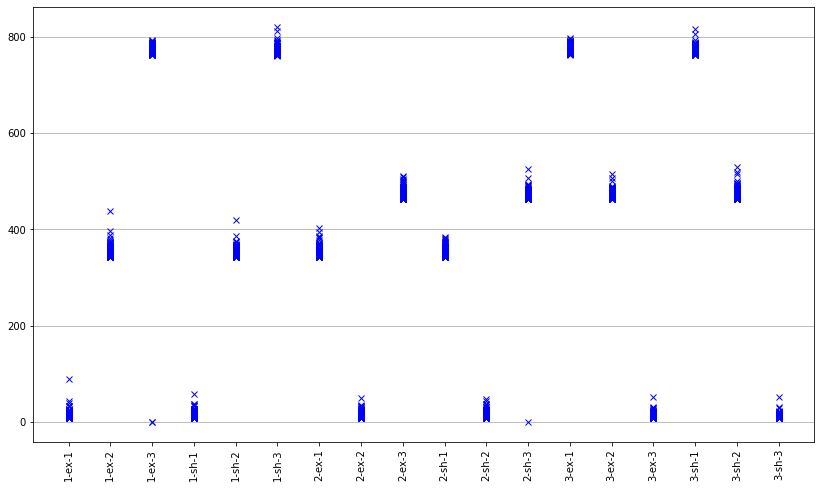

In [6]:
folder = os.path.join('/', 'Users', 'snair', 'works', 'dislock-experiments', 'etcd-benchmarks', 'single-cluster')

data = get_log_single(folder)
for d in data:
    print(d)
    print('99th:', np.percentile(data[d],99),'95th', np.percentile(data[d],95),'90th', np.percentile(data[d],90),'75th', np.percentile(data[d],75),'50th', np.percentile(data[d],50), '25th', np.percentile(data[d],25), '10th', np.percentile(data[d],10), '5th', np.percentile(data[d],5), 'mean', np.mean(data[d]))
generate_plots(data)

### Single client sequential operation - no contention - 3 node cluster

read-acquire
99th: 17.088699 95th 12.743522 90th 11.737599 50th 9.06263 mean 9.430418154845157
read-release
99th: 9.155885 95th 7.059484 90th 6.465039 50th 4.774718 mean 5.11891608991009
write-acquire
99th: 17.74352 95th 14.185205 90th 12.94429 50th 10.077105 mean 10.573776497502497
write-release
99th: 9.533844 95th 7.597998 90th 6.875759 50th 4.981449 mean 5.257500434565435


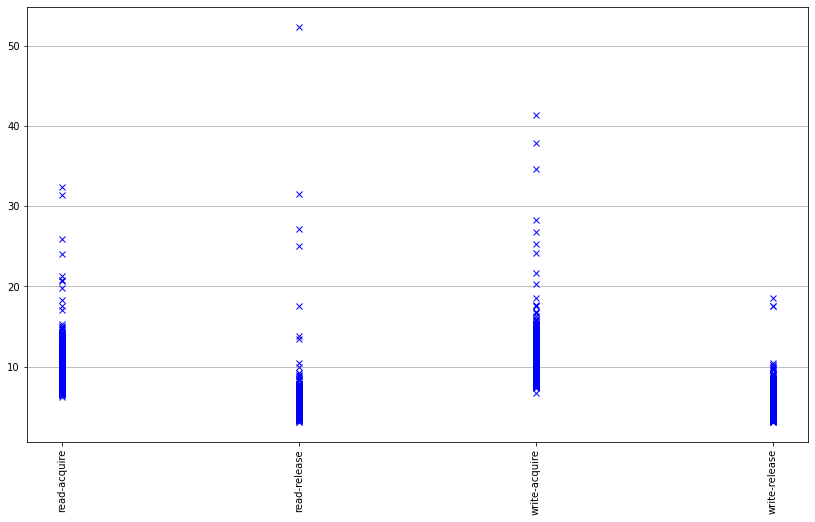

In [7]:
folder = os.path.join('/', 'Users', 'snair', 'works', 'go', 'src', 'github.com', 'sreeja', 'etcd-exp', 'cluster3')

log = get_log(folder)
for d in log:
    print(d)
    print('99th:', np.percentile(log[d],99),'95th', np.percentile(log[d],95),'90th', np.percentile(log[d],90),'50th', np.percentile(log[d],50), 'mean', np.mean(log[d]))
generate_plots(log)

### Concurrent operation with 5 clients - 3node cluster

0read-acquire
99th: 137.39680835000001 95th 70.72764064999993 90th 41.29713960000001 50th 16.504123 mean 24.033538940397726
0read-release
99th: 33.77020929 95th 22.227164599999995 90th 18.3368568 50th 7.501024 mean 10.094194685314685
0write-acquire
99th: 163.01642965 95th 131.60299569999998 90th 124.89271280000001 50th 16.698897000000002 mean 60.62733072385683
0write-release
99th: 15.467252180000001 95th 11.214677349999995 90th 9.703355100000001 50th 6.104472 mean 6.752877042957042
1read-acquire
99th: 133.754372 95th 82.083673 90th 49.683054 50th 27.597667 mean 33.76451514434343
1read-release
99th: 41.347265 95th 26.332971 90th 20.737035 50th 12.96454 mean 14.544204330669329
1write-acquire
99th: 179.286652 95th 140.976778 90th 133.916267 50th 112.924422 mean 114.00262322030335
1write-release
99th: 20.505355 95th 12.822137 90th 11.048469 50th 7.067065 mean 7.8892269522163065
2read-acquire
99th: 130.401732 95th 75.046608 90th 48.654364 50th 27.416665 mean 33.235565608185475
2read-release

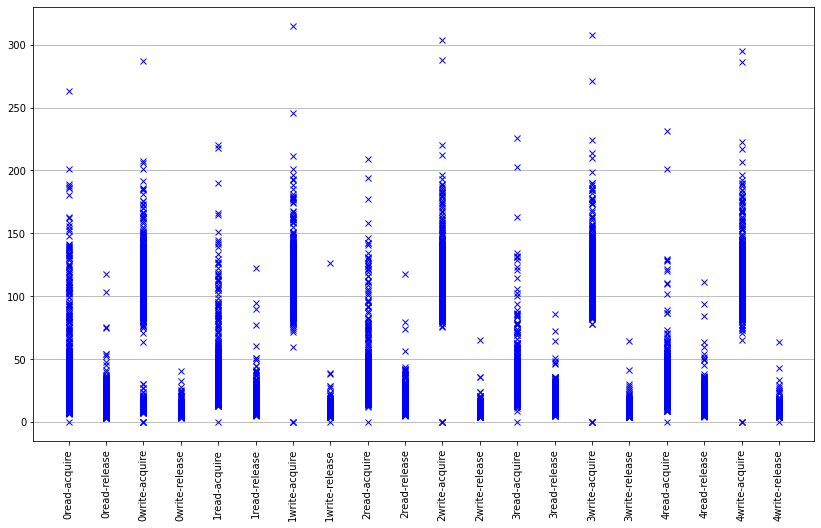

In [8]:
data = get_data(folder)
for d in data:
    print(d)
    print('99th:', np.percentile(data[d],99),'95th', np.percentile(data[d],95),'90th', np.percentile(data[d],90),'50th', np.percentile(data[d],50), 'mean', np.mean(data[d]))
generate_plots(data)



## Single client sequential operation - no contention - 5 node cluster

read-acquire
99th: 109.214478 95th 72.139109 90th 43.355367 50th 28.557494 mean 33.480469491508494
read-release
99th: 65.548217 95th 29.845369 90th 22.117444 50th 15.445575 mean 17.565497604395606
write-acquire
99th: 118.368379 95th 82.355141 90th 57.819911 50th 35.247523 mean 41.032734271728266
write-release
99th: 65.387898 95th 29.385933 90th 23.767709 50th 15.660389 mean 17.919176665334668


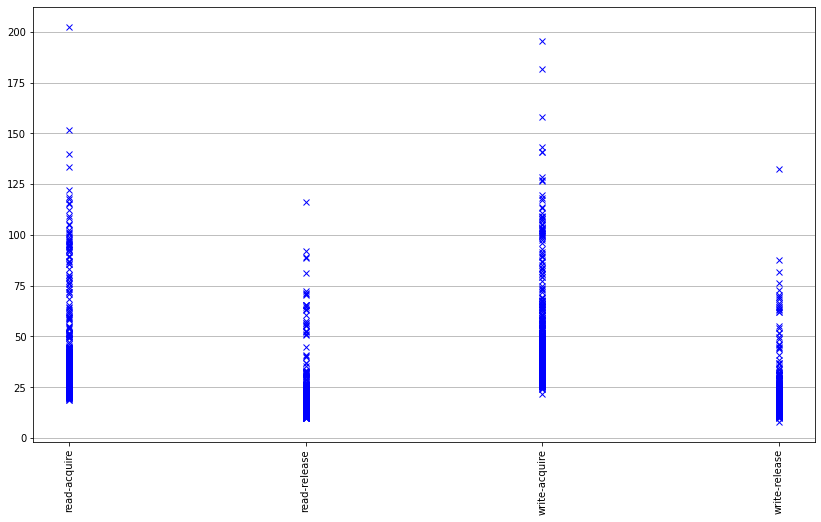

In [9]:
folder = os.path.join('/', 'Users', 'snair', 'works', 'go', 'src', 'github.com', 'sreeja', 'etcd-exp', 'cluster5')

log = get_log(folder)
for d in log:
    print(d)
    print('99th:', np.percentile(log[d],99),'95th', np.percentile(log[d],95),'90th', np.percentile(log[d],90),'50th', np.percentile(log[d],50), 'mean', np.mean(log[d]))
generate_plots(log)

###  5 concurrent clients  5 node cluster

0read-acquire
99th: 612.45918381 95th 221.6730538 90th 188.2158346 50th 101.233318 mean 124.77731476470588
0read-release
99th: 329.75410037999995 95th 122.19913504999995 90th 91.26744760000001 50th 48.828667499999995 mean 62.41450860784313
0write-acquire
0write-release
1read-acquire
99th: 545.233919 95th 337.985324 90th 196.936736 50th 66.755111 mean 98.42528462429233
1read-release
99th: 392.533478 95th 155.738282 90th 106.197705 50th 31.70651 mean 51.64794727672328
1write-acquire
99th: 538.3163723999998 95th 350.91080250000005 90th 171.5181615 50th 61.6427795 mean 92.62760019736842
1write-release
99th: 349.20327789999993 95th 175.17595325 90th 75.8989475 50th 22.420320500000003 mean 43.66167772149122
2read-acquire
99th: 366.43685567999995 95th 205.51462619999995 90th 174.8374976 50th 103.972661 mean 116.7279973732737
2read-release
99th: 232.6464657999987 95th 120.63650359999997 90th 87.57288140000001 50th 48.551269 mean 59.50272035233161
2write-acquire
2write-release
3read-acquire
99t

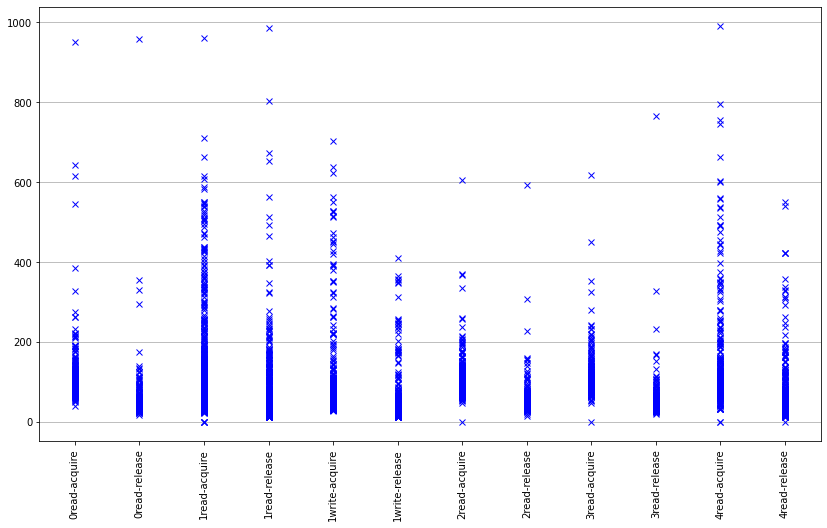

In [10]:
data = get_data(folder)
for d in data:
    print(d)
    if data[d]:
        print('99th:', np.percentile(data[d],99),'95th', np.percentile(data[d],95),'90th', np.percentile(data[d],90),'50th', np.percentile(data[d],50), 'mean', np.mean(data[d]))
generate_plots(data)